In [1]:
import src.acquire
import src.prepare
import src.explore
import src.model

In [2]:
path='zillow_df.csv'

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((12224, 15), (5240, 15), (4366, 15))

In [3]:
# Code to run before explore and modeling

X_train_explore.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_train_explore.drop(columns = ['delete','delete1','yearbuilt'], inplace = True)
X_train_scaled.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_train_scaled.drop(columns = ['delete','delete1'], inplace = True)
X_validate_scaled.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_validate_scaled.drop(columns = ['delete','delete1'], inplace = True)
X_test_scaled.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_test_scaled.drop(columns = ['delete','delete1'], inplace = True)

In [4]:
X_train_explore

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplace,garage,hottub_spa,lotsizesquarefeet,poolcnt,roomcnt,taxvaluedollarcnt,zip,useid,year,zip_cc,useid_cc,year_cc
11961,1.0,3.0,1480.0,1.0,1.0,0.0,6500.0,0.0,6.0,209045.0,97101.0,261.0,1938.0,360,4,51
13861,2.0,2.0,880.0,0.0,1.0,0.0,0.0,0.0,0.0,263933.0,97068.0,266.0,1997.0,348,8,110
17463,2.0,2.0,891.0,0.0,0.0,0.0,32915.0,0.0,0.0,223000.0,96341.0,266.0,1987.0,190,8,100
10288,1.0,2.0,819.0,0.0,0.0,0.0,6299.0,0.0,0.0,367511.0,96023.0,261.0,1922.0,38,4,35
11486,2.0,4.0,1614.0,0.0,0.0,0.0,5008.0,0.0,0.0,67469.0,96111.0,261.0,1956.0,80,4,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15223,3.0,5.0,2712.0,0.0,0.0,0.0,6142.0,0.0,0.0,509851.0,96356.0,269.0,1998.0,198,9,111
9390,3.0,4.0,2966.0,2.0,2.0,0.0,8050.0,1.0,9.0,638507.0,96987.0,261.0,1978.0,308,4,91
7485,3.0,3.0,2204.0,2.0,2.0,0.0,6000.0,0.0,6.0,598000.0,97107.0,261.0,1989.0,363,4,102
20811,3.0,3.0,1217.0,0.0,0.0,0.0,1351.0,0.0,0.0,275835.0,96378.0,269.0,1972.0,210,9,85


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Explore

MVP- 3 Features
1. calculatedfinishedsquarefeet
2. bedroomcnt
3. bathroomcnt

Target = taxvaluedollarcnt

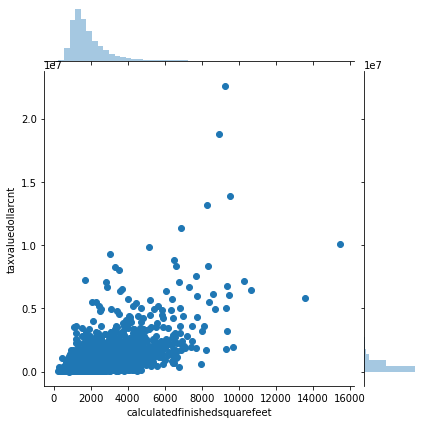

In [10]:
sns.jointplot(x='calculatedfinishedsquarefeet',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

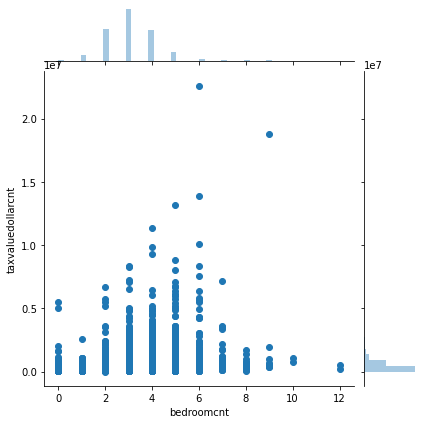

In [11]:
sns.jointplot(x='bedroomcnt',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

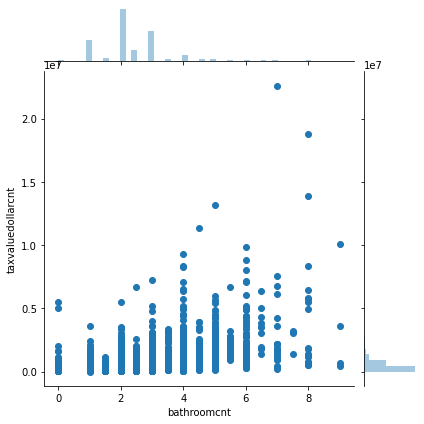

In [12]:
sns.jointplot(x='bathroomcnt',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

#### Takeaway:

1. The only feature that appears to correlate wth the target in a linear fashion is calculatedfinishedsqure feet
2. Lets test if the featues are statistically significant to use

## Notes

1. I already uploaded my env.py file so need need to upload yours.  We only need one to access the data.


2. I already uploaded a .gitignore so also no worries there


3. Data is ready to go, i want to engeneer a feature that combines bed and bath, but get a weird error when I try.    we can trouble shoot after mvp, but code can be found in .prepare file


4. I want to leave 2 categorical variables after transforming them to numeric but I also need help with that
   - "regionidzip"
   - "propertylandusetypeid"
   - They need to be made in to categories before we can do any testing on them (Cat to Numeric)


5. id.1 and Unmaed:0 showd up we also need to delete them